In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#function to convert all images from bgr to rgb and resizing
#getting all image data in the form of a list called 'data' split into different class folders

labels = ['cloudy','foggy','rainy','shine']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        i=0
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)
        #print(class_num)
        for img in os.listdir(path):
            try:
                i+=1
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] # Convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshape images to preferred size
                if [resized_arr, class_num]!=None:
                  data.append([resized_arr, class_num])
                #print(i, end=' ')
            except Exception as e:
                print(e)
        #print()
    return data # Don't convert to a NumPy array here

In [ ]:
#loading test and train images
train = get_data('/content/drive/MyDrive/PESUIO/dataset/new/train')
test = get_data('/content/drive/MyDrive/PESUIO/dataset/new/test')

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


Text(0.5, 1.0, 'cloudy')

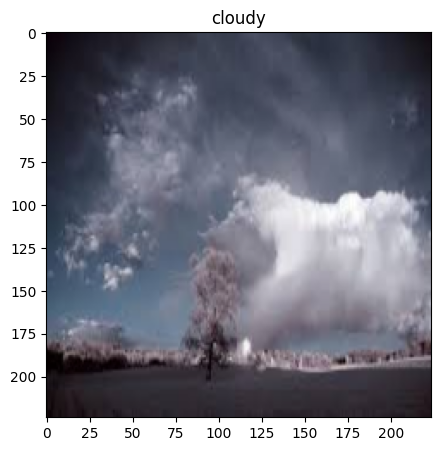

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'shine')

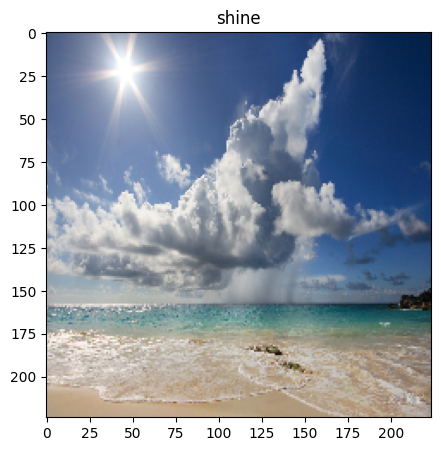

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [ ]:
#duplicating data into lists with elements [feature,label]
#train-training val-testing

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
datagen.fit(x_train)

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224,224,3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
)

# Add a global average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a fully connected layer with one neuron for binary classification
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

# Combine the base model and the custom classification layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Appropriate for one-hot encoded labels
              metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 14.4 MB/s eta 0:00:00


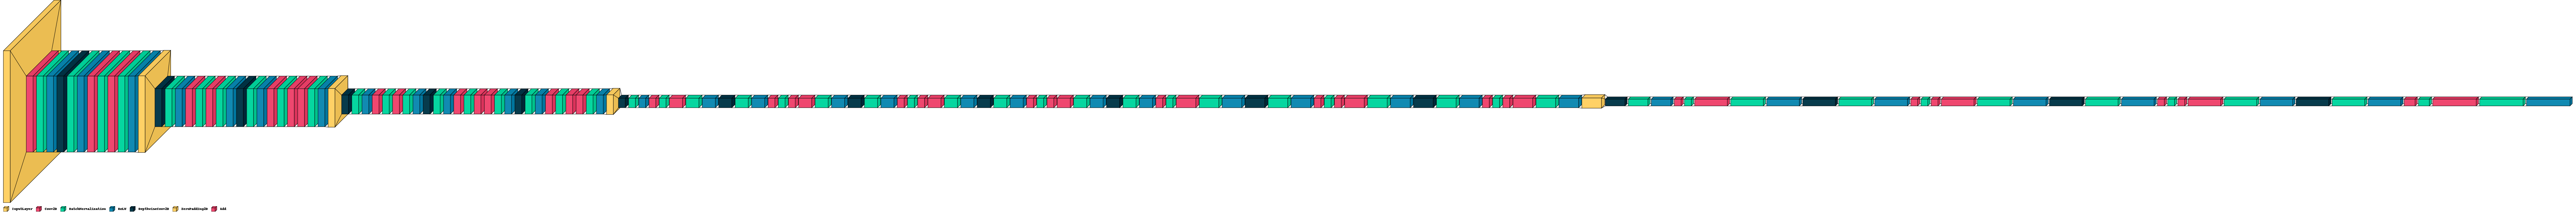

In [ ]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(base_model).show() # display model architecture
visualkeras.layered_view(base_model, legend=True,scale_xy=2)

In [ ]:
# Train the model
history = model.fit(x_train, y_train_encoded, epochs=10, steps_per_epoch=8,
                    validation_data=(x_val, y_val_encoded), verbose=1)


# Save the trained model
base_model.save('weather_mobilenet.h5')

Epoch 1/10
8/8 [==============================] - 56s 7s/step - loss: 1.3615 - accuracy: 0.3621 - val_loss: 1.0016 - val_accuracy: 0.5826
Epoch 2/10
8/8 [==============================] - 56s 7s/step - loss: 0.7185 - accuracy: 0.7702 - val_loss: 0.7081 - val_accuracy: 0.7478
Epoch 3/10
8/8 [==============================] - 52s 7s/step - loss: 0.4625 - accuracy: 0.8720 - val_loss: 0.5746 - val_accuracy: 0.8000
Epoch 4/10
8/8 [==============================] - 61s 8s/step - loss: 0.3526 - accuracy: 0.9015 - val_loss: 0.5034 - val_accuracy: 0.8304
Epoch 5/10
8/8 [==============================] - 50s 6s/step - loss: 0.2894 - accuracy: 0.9179 - val_loss: 0.4585 - val_accuracy: 0.8391
Epoch 6/10
8/8 [==============================] - 62s 8s/step - loss: 0.2496 - accuracy: 0.9322 - val_loss: 0.4094 - val_accuracy: 0.8565
Epoch 7/10
8/8 [==============================] - 51s 6s/step - loss: 0.2228 - accuracy: 0.9453 - val_loss: 0.4006 - val_accuracy: 0.8565
Epoch 8/10
8/8 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs_range = range(10)

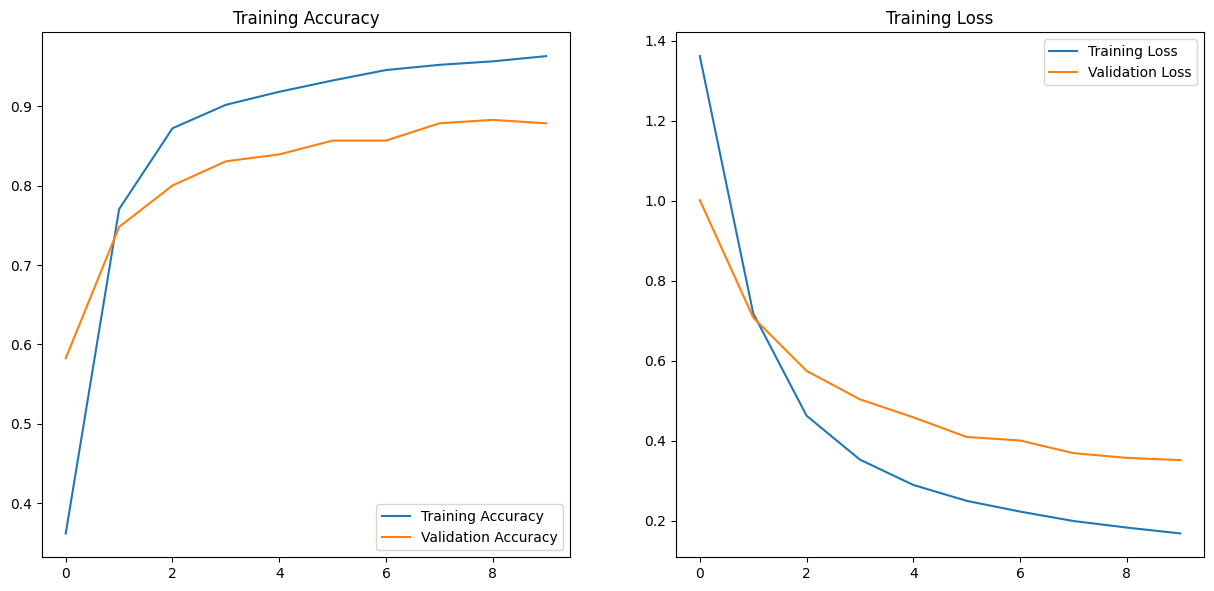

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Load the .h5 model
#model_path = '/content/drive/MyDrive/PESUIO/weather_mobilenet.h5'
#model = tf.keras.models.load_model(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Get class probabilities
class_probabilities = model.predict(x_val)

# Determine predicted classes
#predicted=[]
#for img in class_probabilities:
 # max_value = max(img)
  #max_index = list(class_probabilities[img]).index(max_value)
  #predicted.append(max_index)
predicted_classes = np.argmax(class_probabilities, axis=1)

# Print or use predicted classes
print(predicted_classes)

8/8 [==============================] - 11s 1s/step
[0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 1 2 2 3 0 3 3 3
 3 3 3 3 3 3 3 0 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 0 3 3 3 3 0 0 3 3 0
 3 3 3 3 3 3 3 3]


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming 'y_val' contains the true class labels (ground truth) and 'predictions' contains the predicted class labels
# Define the target class names for the report (4 classes in this case)
target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Generate the classification report
report = classification_report(y_val, predicted_classes, target_names=target_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Class 0       0.87      0.92      0.89        60
     Class 1       0.80      0.98      0.88        60
     Class 2       0.96      0.77      0.85        60
     Class 3       0.93      0.84      0.88        50

    accuracy                           0.88       230
   macro avg       0.89      0.88      0.88       230
weighted avg       0.89      0.88      0.88       230



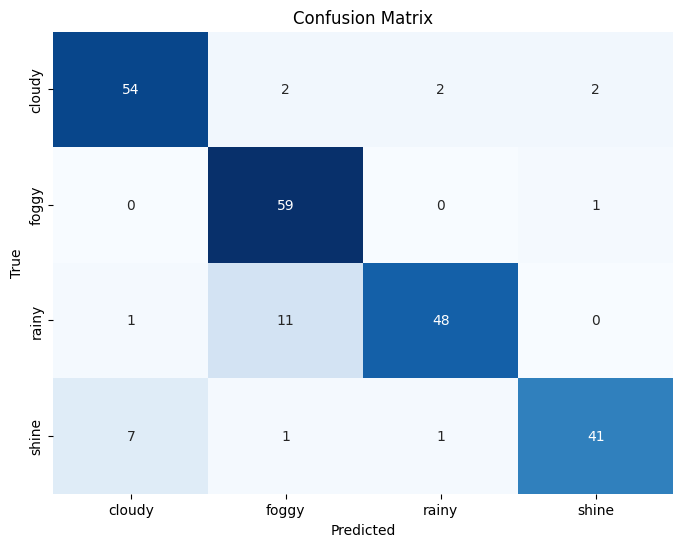

Label: cloudy
True Positives (TP): 54
True Negatives (TN): 162
False Positives (FP): 6
False Negatives (FN): 8

Label: foggy
True Positives (TP): 59
True Negatives (TN): 156
False Positives (FP): 1
False Negatives (FN): 14

Label: rainy
True Positives (TP): 48
True Negatives (TN): 167
False Positives (FP): 12
False Negatives (FN): 3

Label: shine
True Positives (TP): 41
True Negatives (TN): 177
False Positives (FP): 9
False Negatives (FN): 3



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate the confusion matrix
confusion = confusion_matrix(np.argmax(y_val_encoded, axis=1), predicted_classes)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Extract TP, TN, FP, and FN values from the confusion matrix
tp = confusion.diagonal()
tn = np.sum(confusion) - np.sum(confusion, axis=0) - np.sum(confusion, axis=1) + tp
fp = np.sum(confusion, axis=1) - tp
fn = np.sum(confusion, axis=0) - tp
# Print TP, TN, FP, and FN values
for i, label in enumerate(labels):
    print(f"Label: {label}")
    print(f"True Positives (TP): {tp[i]}")
    print(f"True Negatives (TN): {tn[i]}")
    print(f"False Positives (FP): {fp[i]}")
    print(f"False Negatives (FN): {fn[i]}\n")

1/1 [==============================] - 0s 82ms/step


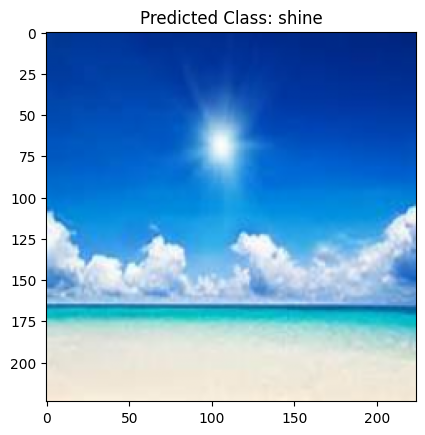

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the input image
input_image_path = '/content/drive/MyDrive/PESUIO/dataset/new/alien/shine_1.jpg'
input_image = cv2.imread(input_image_path)[..., ::-1]  # Convert BGR to RGB
input_image = cv2.resize(input_image, (224, 224))  # Resize to 224x224 pixels
input_image = input_image / 255.0  # Normalize pixel values to [0, 1]

# Make predictions using the trained model
class_probabilities = model.predict(np.expand_dims(input_image, axis=0))
predicted_class_index = np.argmax(class_probabilities)
predicted_class_label = labels[predicted_class_index]

# Display the input image, predicted class, and class probabilities (if needed)
plt.imshow(input_image)
plt.title(f'Predicted Class: {predicted_class_label}')
plt.show()